##### Import and Defining Functions

In [2]:
# Import Required Libraries

import pandas as pd
import math
import numpy as np

import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.offline import iplot

from prophet import Prophet
import holidays
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
import os

from sklearn.model_selection import train_test_split

import shap

C:\Users\Arcega\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [3]:
def is_weekend(ds):
    date = pd.to_datetime(ds)
    # Return True for Saturday (5) and Sunday (6), False otherwise
    return date.weekday() >= 5

def mean_absolute_scaled_error(y_true, y_pred):
    seasonality = 20

    seasonal_naive = test.copy()
    seasonal_naive['yhat'] = test['y'].shift(20)
    seasonal_naive['yhat'].fillna(test['y'][:20].mean(), inplace=True)

    naive_errors = np.abs(seasonal_naive['y'] - seasonal_naive['yhat'])

    # Mean absolute error of the naive forecast
    naive_mae = np.mean(naive_errors)
    naive_mae

    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate the absolute error of the model's predictions
    abs_error = np.mean(np.abs(y_true - y_pred))
    
    mase = abs_error / naive_mae

    return mase

def evaluate_model(test, test_forecast):
    # Evaluate performance
    mse = mean_squared_error(y_true=test['y'],  y_pred=test_forecast['yhat'])
    rmse = np.sqrt(mean_squared_error(y_true=test['y'], y_pred=test_forecast['yhat']))
    mae = mean_absolute_error(y_true=test['y'], y_pred=test_forecast['yhat'])
    r2 = r2_score(y_true=test['y'], y_pred=test_forecast['yhat'])
    return mse, rmse, mae, r2

def df_to_X_y(df, window_size=6):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i:i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size][7]  # 'Entry' is the 8th column (index 7)
        y.append(label)
    return np.array(X), np.array(y)



##### Prophet Model

In [4]:
# Import dataset
df = pd.read_csv('2223TaftProphet.csv', parse_dates=[0])
df

,Datetime,Entry,is_weekend,rain_amount
0,2022-01-01 04:00:00,0,1,0.0
1,2022-01-01 05:00:00,0,1,0.0
2,2022-01-01 06:00:00,525,1,0.0
3,2022-01-01 07:00:00,610,1,0.0
4,2022-01-01 08:00:00,684,1,0.0
...,...,...,...,...
14595,2023-12-31 19:00:00,1681,1,0.0
14596,2023-12-31 20:00:00,297,1,0.0
14597,2023-12-31 21:00:00,0,1,0.0
14598,2023-12-31 22:00:00,0,1,0.0


In [5]:
# Rename header to Prophet's requirements
df.reset_index()
df = df.rename(columns={'Datetime':'ds', 'Entry':'y'})

# Add additional regressors as columns in the dataframe
df['hour'] = pd.to_datetime(df['ds']).dt.hour
df['off_hour'] = df['hour'].apply(lambda x: 1 if (x >= 23) or (x <= 3) else 0)
df['weekday'] = ~df['ds'].apply(is_weekend)
df['weekend'] = df['ds'].apply(is_weekend)

# Extract year, month, day, day of the week, and hour into separate columns
df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month
df['day'] = df['ds'].dt.day
df['day_of_week'] = df['ds'].dt.dayofweek  # Monday=0, Sunday=6
df['hour'] = df['ds'].dt.hour

#df['school_year'] = False
#df['f2f_class'] = False

# Define the school year periods
#school_period_1 = (df['ds'] >= '2022-01-01 04:00:00') & (df['ds'] <= '2022-06-24 23:00:00')
#school_period_2 = (df['ds'] >= '2022-08-22 04:00:00') & (df['ds'] <= '2023-07-07 23:00:00')
#school_period_3 = (df['ds'] >= '2023-08-29 04:00:00') & (df['ds'] <= '2023-12-31 23:00:00')

#f2f_period = (df['ds'] >= '2022-11-02 04:00:00') & (df['ds'] <= '2023-12-31 23:00:00')

# Set 'school_active' to 1 (active) during these periods
#df.loc[school_period_1 | school_period_2 | school_period_3, 'school_year'] = True
#df.loc[f2f_period, 'f2f_class'] = True

df

,ds,y,is_weekend,rain_amount,hour,off_hour,weekday,weekend,year,month,day,day_of_week
0,2022-01-01 04:00:00,0,1,0.0,4,0,False,True,2022,1,1,5
1,2022-01-01 05:00:00,0,1,0.0,5,0,False,True,2022,1,1,5
2,2022-01-01 06:00:00,525,1,0.0,6,0,False,True,2022,1,1,5
3,2022-01-01 07:00:00,610,1,0.0,7,0,False,True,2022,1,1,5
4,2022-01-01 08:00:00,684,1,0.0,8,0,False,True,2022,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
14595,2023-12-31 19:00:00,1681,1,0.0,19,0,False,True,2023,12,31,6
14596,2023-12-31 20:00:00,297,1,0.0,20,0,False,True,2023,12,31,6
14597,2023-12-31 21:00:00,0,1,0.0,21,0,False,True,2023,12,31,6
14598,2023-12-31 22:00:00,0,1,0.0,22,0,False,True,2023,12,31,6


In [6]:
# Split the dataset to training and testing sets
train_len = math.floor((df.shape[0]*80)/100)
train = df[:train_len]
test = df[train_len:]
test_len = math.floor((test.shape[0]*50)/100)
val = test[:test_len]
test = test[test_len:]

train.shape, val.shape, test.shape

((11680, 12), (1460, 12), (1460, 12))

In [7]:
test

,ds,y,is_weekend,rain_amount,hour,off_hour,weekday,weekend,year,month,day,day_of_week
13140,2023-10-20 04:00:00,0,0,26.5,4,0,True,False,2023,10,20,4
13141,2023-10-20 05:00:00,2894,0,26.5,5,0,True,False,2023,10,20,4
13142,2023-10-20 06:00:00,4339,0,26.5,6,0,True,False,2023,10,20,4
13143,2023-10-20 07:00:00,5548,0,26.5,7,0,True,False,2023,10,20,4
13144,2023-10-20 08:00:00,4502,0,26.5,8,0,True,False,2023,10,20,4
...,...,...,...,...,...,...,...,...,...,...,...,...
14595,2023-12-31 19:00:00,1681,1,0.0,19,0,False,True,2023,12,31,6
14596,2023-12-31 20:00:00,297,1,0.0,20,0,False,True,2023,12,31,6
14597,2023-12-31 21:00:00,0,1,0.0,21,0,False,True,2023,12,31,6
14598,2023-12-31 22:00:00,0,1,0.0,22,0,False,True,2023,12,31,6


In [8]:
# Create holidays dataframe
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Philippines(years=[2022, 2023]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': name}, index=[0])], ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.loc[holiday['ds'] == '2023-11-30', 'ds'] = '2023-11-27'

holiday.head(40)


,ds,holiday
0,2022-01-01,New Year's Day
1,2022-02-01,Chinese New Year
2,2022-02-25,EDSA Revolution Anniversary
3,2022-04-09,Day of Valor
4,2022-04-14,Maundy Thursday
5,2022-04-15,Good Friday
6,2022-04-16,Black Saturday
7,2022-05-01,Labour Day
8,2022-05-02,Eid'l Fitr (estimated)
9,2022-06-12,Independence Day


In [9]:
# Initialize the Prophet model
m = Prophet(
    yearly_seasonality=True,
    daily_seasonality=False,
    weekly_seasonality=True,
    holidays=holiday,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.001,
    seasonality_prior_scale=0.1
)

# Add the regressors
m.add_seasonality(name='daily_is_weekend', period=1, fourier_order=4, condition_name='weekend')
m.add_seasonality(name='daily_is_weekday', period=1, fourier_order=4, condition_name='weekday')
m.add_regressor('off_hour')
m.add_regressor('rain_amount')
#m.add_regressor('off_hour')
#m.add_regressor('school_year')

# Fit the model on the training data
m.fit(train)

04:06:21 - cmdstanpy - INFO - Chain [1] start processing
04:06:25 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
# Make predictions for Test set
test_forecast = m.predict(test)

# Remove negative forecasts
test_forecast['yhat'] = test_forecast['yhat'].apply(lambda x: max(x, 0))
test_forecast['yhat_lower'] = test_forecast['yhat_lower'].apply(lambda x: max(x, 0))
test_forecast['yhat_upper'] = test_forecast['yhat_upper'].apply(lambda x: max(x, 0))

# Round forecast values
test_forecast['yhat'] = test_forecast['yhat'].round()

test_forecast.head(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,All Saints' Day,All Saints' Day_lower,All Saints' Day_upper,Black Saturday,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2023-10-20 04:00:00,1461.835412,0.000000,294.403786,1461.835412,1461.835412,0.0,0.0,0.0,0.0,...,-0.030464,-0.030464,-0.030464,-0.126048,-0.126048,-0.126048,0.0,0.0,0.0,0.0
1,2023-10-20 05:00:00,1461.852294,1320.750818,2675.816568,1461.852294,1461.852294,0.0,0.0,0.0,0.0,...,-0.024799,-0.024799,-0.024799,-0.126362,-0.126362,-0.126362,0.0,0.0,0.0,2043.0
2,2023-10-20 06:00:00,1461.869177,2979.796404,4267.167698,1461.869177,1461.869177,0.0,0.0,0.0,0.0,...,-0.018761,-0.018761,-0.018761,-0.126678,-0.126678,-0.126678,0.0,0.0,0.0,3624.0
3,2023-10-20 07:00:00,1461.886059,3434.188477,4695.703947,1461.886059,1461.886059,0.0,0.0,0.0,0.0,...,-0.012417,-0.012417,-0.012417,-0.126997,-0.126997,-0.126997,0.0,0.0,0.0,4063.0
4,2023-10-20 08:00:00,1461.902942,3041.668962,4275.650777,1461.902942,1461.902942,0.0,0.0,0.0,0.0,...,-0.005840,-0.005840,-0.005840,-0.127316,-0.127316,-0.127316,0.0,0.0,0.0,3637.0


In [11]:
# Create a future DataFrame with hourly intervals for the desired forecast period
future = m.make_future_dataframe(periods=150, freq='D')
future['hour'] = pd.to_datetime(future['ds']).dt.hour
future['is_weekend'] = df['is_weekend']
future['weekday'] = future['ds'].apply(is_weekend)
future['weekend'] = ~future['ds'].apply(is_weekend)
future['rain_amount'] = df['rain_amount']
future['off_hour'] = future['hour'].apply(lambda x: 1 if (x >= 23) or (x <= 3) else 0)
future = future[future['ds'].dt.hour < 23]
future = future[future['ds'].dt.hour > 3]

# Make predictions
forecast = m.predict(future)
forecast['yhat'] = forecast['yhat'].apply(lambda x: max(x, 0))
forecast['yhat_lower'] = forecast['yhat_lower'].apply(lambda x: max(x, 0))
forecast['yhat_upper'] = forecast['yhat_upper'].apply(lambda x: max(x, 0))
forecast['yhat'] = forecast['yhat'].round()
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2022-01-01 04:00:00,0.0,0.000000,432.783935
1,2022-01-01 05:00:00,1180.0,547.077086,1794.878333
2,2022-01-01 06:00:00,2099.0,1501.764087,2722.087867
3,2022-01-01 07:00:00,2346.0,1721.253318,2980.014147
4,2022-01-01 08:00:00,2084.0,1441.523489,2695.828008


In [12]:
mse = mean_squared_error(y_true=test['y'],  y_pred=test_forecast['yhat'])
rmse = np.sqrt(mean_squared_error(y_true=test['y'], y_pred=test_forecast['yhat']))
mae = mean_absolute_error(y_true=test['y'], y_pred=test_forecast['yhat'])
r2 = r2_score(y_true=test['y'], y_pred=test_forecast['yhat'])
mase = mean_absolute_scaled_error(y_true=test['y'],  y_pred=test_forecast['yhat'])

prophet_eval = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R^2 Score', 'MASE'],
    'Value': [mse, rmse, mae, r2, mase]
})

prophet_eval

C:\Users\Arcega\AppData\Local\Temp\ipykernel_14848\3794208353.py:11: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



,Metric,Value
0,MSE,446872.922603
1,RMSE,668.485544
2,MAE,516.955479
3,R^2 Score,0.756591
4,MASE,1.237387


##### SHAP Implementation

###### LSTM w/ SHAP

###### Prophet w/ SHAP


In [ ]:

# Prepare the data for SHAP
# Use the same features that were used in the Prophet model
shap_features = ['ds', 'year','month', 'day', 'day_of_week', 'hour','off_hour', 'rain_amount', 'weekday', 'weekend']

# Extract the feature values from the test set
shap_values_df = df[shap_features]

# select random samples
shap_values_df = shap_values_df.sample(n=100, random_state=42)

def prophet_predict(data):
    future = pd.DataFrame(data, columns=['ds', 'year','month', 'day', 'day_of_week', 'hour','off_hour', 'rain_amount', 'weekday', 'weekend'])
    forecast = m.predict(future)
    return forecast['yhat'].values

# Initialize SHAP KernelExplainer with the Prophet model
explainer = shap.KernelExplainer(prophet_predict, shap_values_df)

# Compute SHAP values for the test set
shap_values = explainer(shap_values_df)

# Plot the SHAP summary
shap.summary_plot(shap_values, shap_values_df, feature_names=shap_features)

  7%|▋         | 7/100 [03:05<38:27, 24.81s/it]

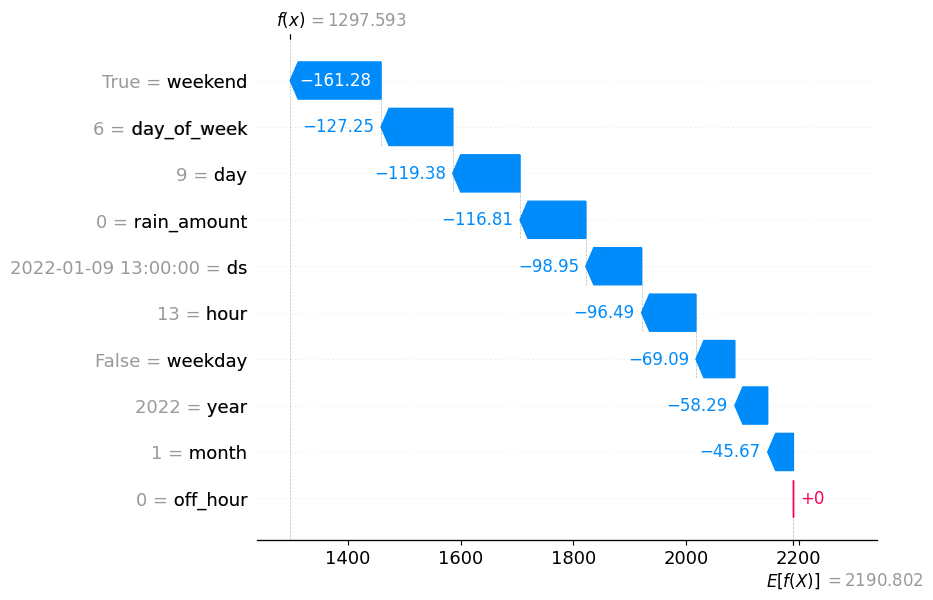

In [ ]:
shap.plots.waterfall(shap_values[0])

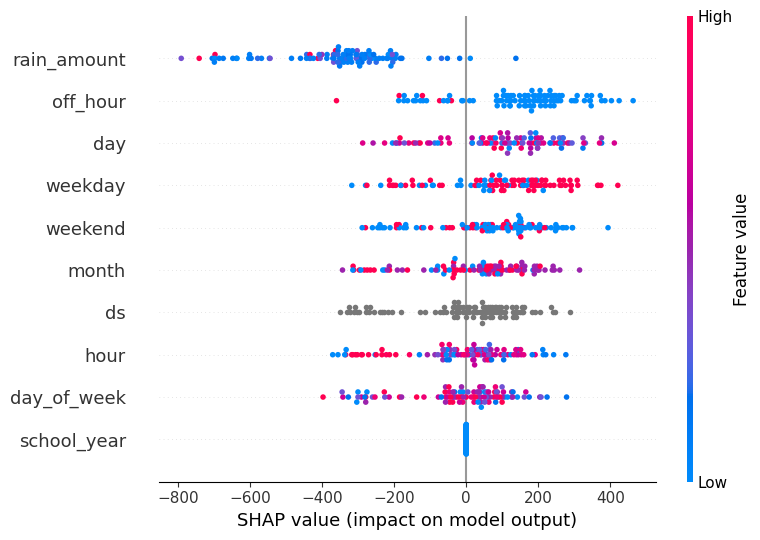

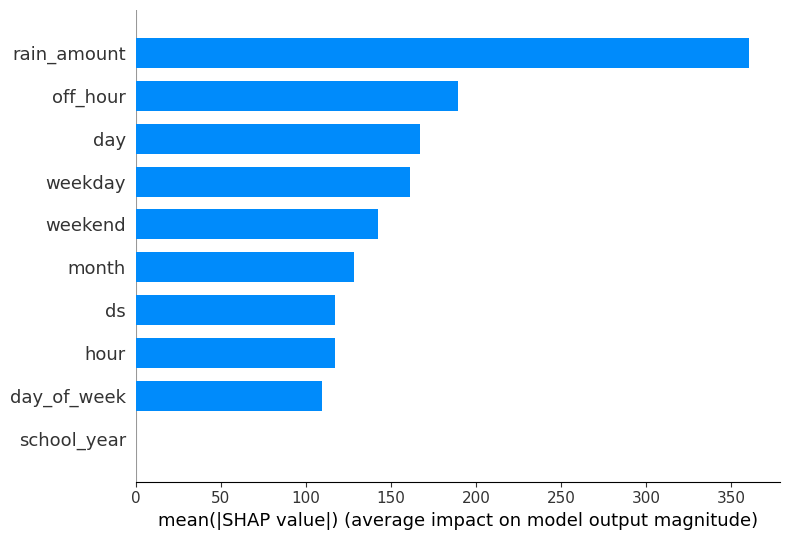

In [ ]:
# Plot the SHAP summary
shap.summary_plot(shap_values, shap_values_df, feature_names=shap_features)
shap.summary_plot(shap_values, shap_values_df, feature_names=shap_features,plot_type="bar")

In [ ]:
# To display all columns in the DataFrame
pd.set_option('display.max_columns', None)

# Now, when you print the DataFrame, it will show all the columns
test_forecast

In [22]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


In [ ]:
hybrid_actual